<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Quantum Random Number Generation*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

***
### Contributors
James R. Wootton, IBM Research
***

### Qiskit Package Versions

In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit': '0.10.3',
 'qiskit-terra': '0.8.1',
 'qiskit-ignis': '0.1.1',
 'qiskit-aer': '0.2.1',
 'qiskit-ibmq-provider': '0.2.2',
 'qiskit-aqua': '0.5.1'}

One important application of quantum computers is the generation of random numbers. This could be a simple as a coin flip.

In [2]:
import random
for n in range(5):
    print('Flip '+str(n+1))
    if random.random()<0.5:
        print('HEADS\n')
    else:
        print('TAILS\n')

Flip 1
HEADS

Flip 2
HEADS

Flip 3
TAILS

Flip 4
HEADS

Flip 5
HEADS



The above code doesn't use Qiskit. Instead it uses an entirely classical package unimaginatively called `random`. There are many classical methods that can be used for this purpose, but none are truly random. Instead, they are *pseudorandom number generators*. They produce an output by taking a definite input and processing it in a deterministic way. These inputs are chosen such that the result appears random, and the processing is usually designed to accentuate this. But nevertheless, if you knew what was going on under the hood, you'd know exactly what random numbers would come out.

For example, suppose we take an extremely precise measure of the time at which the random number was asked for. We could then look at the last digit (which changes most quickly), and assign our heads or tails depending on whether this is even or odd. Slight fluctations in the speed of our process will result in random seeming numbers.

In [3]:
import time
for n in range(5):
    t = str(time.time())
    print('Flip '+str(n+1)+'  (system time = ' + t + ')')
    if int(t[-1])%2==0:
        print('HEADS\n')
    else:
        print('TAILS\n')

Flip 1  (system time = 1559624910.322222)
HEADS

Flip 2  (system time = 1559624910.322349)
TAILS

Flip 3  (system time = 1559624910.322529)
TAILS

Flip 4  (system time = 1559624910.3225758)
HEADS

Flip 5  (system time = 1559624910.32261)
TAILS



This already does a fairly good job at seeming random, and more sophisticated methods will do even better, but all have their limits. This can be an important issue, since some applications rely on having good quality random numbers. For example:

* Simulations of random processes may have skewed statistics for bad quality randomness;


* Cryptography can be cracked if the key is created using poorly generated random numbers.

We can solve these problems using the most genuine source of randomness that we know: measurements of quantum superpositions. Unlike a pseudorandom number generator, a qubit does not know what result it will give. It does not contain a definite set of details that tell it how to respond to any measurement it may experience. The result is completely undefined before the moment of measurement. This means we can use quantum computers for the ultimate coin flip.

## Quantum coin flip

To generate a single random bit, we need only one qubit.

In [4]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

q = QuantumRegister(1)
c = ClassicalRegister(1)
circ = QuantumCircuit(q, c)

We need to generate an equally weighted superposition of $|0\rangle$ and $|1\rangle$ to get a completely random bit. This is done most simply with the Hadamard.

In [5]:
circ.h(q)

To extract the output, we then measure.

In [6]:
circ.measure(q, c)

Now the circuit is complete, let's run it for 5 shots to get 5 results.

In [7]:
from qiskit import BasicAer, execute

backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=5, memory=True)

Our results are extracted from `job.result()` using `get_memory()`.

In [8]:
data = job.result().get_memory()
print(data)

['0', '0', '0', '0', '1']


For a coin flip, we can simply use `0` to mean heads and `1` to mean tails.

In [9]:
for output in data:
    print('Flip with output bit value ' +output)
    if output=='0':
        print('HEADS\n')
    else:
        print('TAILS\n')

Flip with output bit value 0
HEADS

Flip with output bit value 0
HEADS

Flip with output bit value 0
HEADS

Flip with output bit value 0
HEADS

Flip with output bit value 1
TAILS



We cheated above by using the simulator. Since this is a classical reproduction of a qubit, the results here were actually pseudorandom. For real randomness, we need a real device. So let's load an IBMQ account and use a 5 qubit quantum processor.

In [10]:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

IBMQ.load_accounts()

backend = least_busy(IBMQ.backends(operational=True, simulator=False))
job = execute(circ, backend, shots=5, memory=True)

In [11]:
for output in job.result().get_memory():
    print('Flip with output bit value ' +output)
    if output=='0':
        print('HEADS\n')
    else:
        print('TAILS\n')

Flip with output bit value 0
HEADS

Flip with output bit value 0
HEADS

Flip with output bit value 0
HEADS

Flip with output bit value 1
TAILS

Flip with output bit value 1
TAILS



Here's the list of results as we get it from `get_memory()`.

In [12]:
job.result().get_memory()

['0', '0', '0', '1', '1']

Note that noise results in these results typically showing a bias towards `0`. So some post-processing is required if these numbers are to be used for statistical studies. Also, though the universe ensures the cryptographic security of these numbers, their journey between the qubit and your computer might not be so secure. You'll need to take additional precautions before using these results for security applications.

## More general probability distributions

Sometimes we need something more complex than just a coin flip. Many applications require generation of many possible numbers within a certain range (rather than just $0$ and $1$), and to do according probability distribitions for which each outcome could occur with a different probability.

This is also possible for quantum computers. In fact, quantum computers will be able to efficiently sample from probability distributions that would be intractable for classical computers.

To represent numbers larger than $0$ and $1$, we need more qubits. The $n$ bit string from the output of $n$ qubits can then be interpreted as the binary representation of numbers from $0$ to $2^n-1$. For example, let's choose $n=3$ to generate numbers from $0$ to $7$.

In [13]:
n = 3

To get a uniform distribition over all these numbers, we could simply do a Hadamard on each. Here's an implementation of this, with the histogram obtained from many samples.

In [14]:
q = QuantumRegister(n)
c = ClassicalRegister(n)
circ = QuantumCircuit(q, c)

for j in range(n):
    circ.h(q[j])
    
circ.measure(q,c)

job = execute(circ, BasicAer.get_backend('qasm_simulator'), shots=8192)

# get the histogram of bit string results, convert it to one of integers and plot it
bit_counts = job.result().get_counts()
int_counts = {}
for bitstring in bit_counts:
    int_counts[ int(bitstring,2) ] = bit_counts[bitstring]

from qiskit.tools.visualization import plot_histogram    
plot_histogram(int_counts)

<Figure size 700x500 with 1 Axes>

Now let's try something slightly more complex, like a bias towards smaller numbers. This can be done by using the `rx` rotation on each qubit, by using an angle for each `rx` that decreases as we go from `q[0]` (whose output corresponds to the least significant binary digit) to `q[n-1]` (the most significant).

Below is one possible implementation of this. It was chosen fairly arbitrarily, so why not try your own variation?

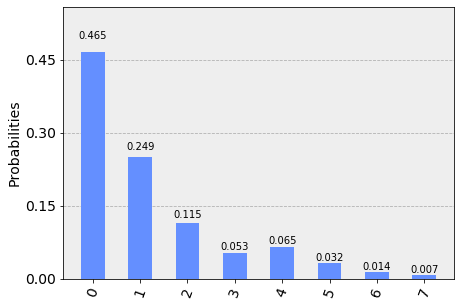

In [15]:
q = QuantumRegister(n)
c = ClassicalRegister(n)
circ = QuantumCircuit(q, c)

for j in range(n):
    circ.rx(3.14159/(2.5+j),q[j])
    
circ.measure(q,c)
    
job = execute(circ, BasicAer.get_backend('qasm_simulator'), shots=8192)

bit_counts = job.result().get_counts()
int_counts = {}
for bitstring in bit_counts:
    int_counts[ int(bitstring,2) ] = bit_counts[bitstring]
plot_histogram(int_counts)

Now let's get some actual random samples from this distribution. Specifically, let's get ten of them.

In [16]:
job = execute(circ, BasicAer.get_backend('qasm_simulator'), shots=10, memory=True)
data = job.result().get_memory()
print(data)

['000', '000', '001', '001', '001', '001', '001', '111', '001', '001']


These are written in binary, but it is straightforward to convert them into decimal integers.

In [17]:
int_data = []
for bitstring in data:
    int_data.append( int(bitstring,2) )
print(int_data)

[0, 0, 1, 1, 1, 1, 1, 7, 1, 1]


Here we see, as we expected, a bias towards the smaller numbers in the range.